In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, metrics
plt.style.use('ggplot')

In [2]:
# Read in the dataframes
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
merch_df = pd.read_csv('../input/merchants.csv')
hist_trans_df = pd.read_csv('../input/historical_transactions.csv')
new_trans_df = pd.read_csv('../input/new_merchant_transactions.csv')
ss_df = pd.read_csv('../input/sample_submission.csv')

In [3]:
# Print data shapes
print('train shape: ', train_df.shape)
print('test shape: ', test_df.shape)
print('merchants shape: ', merch_df.shape)
print('merchants shape: ', hist_trans_df.shape)
print('merchants shape: ', new_trans_df.shape)
print('sample submission shape: ', ss_df.shape)

train shape:  (201917, 6)
test shape:  (123623, 5)
merchants shape:  (334696, 22)
merchants shape:  (29112361, 14)
merchants shape:  (1963031, 14)
sample submission shape:  (123623, 2)


In [4]:
# show some some samples of train data set
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [5]:
# show dataframe types
train_df.dtypes

first_active_month     object
card_id                object
feature_1               int64
feature_2               int64
feature_3               int64
target                float64
dtype: object

In [23]:
# convert the columns into correct format
train_df['first_active_month'] = pd.to_datetime(train_df['first_active_month'])
train_df['feature_1'] = train_df['feature_1'].astype(str)
train_df['feature_2'] = train_df['feature_2'].astype(str)
train_df['feature_3'] = train_df['feature_3'].astype(str)
train_df.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                     object
feature_2                     object
feature_3                     object
target                       float64
dtype: object

In [10]:
# save and compress into parquet file format
train_df.to_parquet('../input/train_df.parquet.gzip',
                    engine='fastparquet',
                    compression='gzip')

In [11]:
# show some some samples of test data set
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [12]:
# show dataframe types
test_df.dtypes

first_active_month    object
card_id               object
feature_1              int64
feature_2              int64
feature_3              int64
dtype: object

In [22]:
# convert the columns into correct format
test_df['first_active_month'] = pd.to_datetime(test_df['first_active_month'])
test_df['feature_1'] = test_df['feature_1'].astype(str)
test_df['feature_2'] = test_df['feature_2'].astype(str)
test_df['feature_3'] = test_df['feature_3'].astype(str)
test_df.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                     object
feature_2                     object
feature_3                     object
dtype: object

In [15]:
# save and compress into parquet file format
test_df.to_parquet('../input/test_df.parquet.gzip',
                   engine='fastparquet',
                   compression='gzip')

In [24]:
# show some some samples of merchant data set
merch_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [25]:
# show dataframe types
merch_df.dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float64
numerical_2                    float64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [26]:
# convert the columns into correct format
merch_df['merchant_group_id'] = merch_df['merchant_group_id'].astype(str)
merch_df['merchant_category_id'] = merch_df['merchant_category_id'].astype(str)
merch_df['subsector_id'] = merch_df['subsector_id'].astype(str)
merch_df['city_id'] = merch_df['city_id'].astype(str)
merch_df['state_id'] = merch_df['state_id'].astype(str)
merch_df['category_2'] = merch_df['category_2'].astype(str)
merch_df.dtypes

merchant_id                     object
merchant_group_id               object
merchant_category_id            object
subsector_id                    object
numerical_1                    float64
numerical_2                    float64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                         object
state_id                        object
category_2                      object
dtype: object

In [27]:
# save and compress into parquet file format
merch_df.to_parquet('../input/merch_df.parquet.gzip',
                    engine='fastparquet',
                    compression='gzip')

In [28]:
# show some some samples of historical transactions data set
hist_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [29]:
# show dataframe types
hist_trans_df.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [30]:
# convert the columns into correct format
hist_trans_df['city_id'] = hist_trans_df['city_id'].astype(str)
hist_trans_df['merchant_category_id'] = hist_trans_df['merchant_category_id'].astype(str)
hist_trans_df['purchase_date'] = pd.to_datetime(hist_trans_df['purchase_date'])
hist_trans_df['category_2'] = hist_trans_df['category_2'].astype(str)
hist_trans_df['state_id'] = hist_trans_df['state_id'].astype(str)
hist_trans_df['subsector_id'] = hist_trans_df['subsector_id'].astype(str)
hist_trans_df.dtypes

authorized_flag                 object
card_id                         object
city_id                         object
category_1                      object
installments                     int64
category_3                      object
merchant_category_id            object
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                      object
state_id                        object
subsector_id                    object
dtype: object

In [31]:
# save and compress into parquet file format
hist_trans_df.to_parquet('../input/hist_trans_df.parquet.gzip',
                         engine='fastparquet',
                         compression='gzip')

In [34]:
# show some some samples of new transactions data set
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [35]:
# show dataframe types
new_trans_df.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [36]:
# convert the columns into correct format
new_trans_df['city_id'] = new_trans_df['city_id'].astype(str)
new_trans_df['merchant_category_id'] = new_trans_df['merchant_category_id'].astype(str)
new_trans_df['purchase_date'] = pd.to_datetime(new_trans_df['purchase_date'])
new_trans_df['category_2'] = new_trans_df['category_2'].astype(str)
new_trans_df['state_id'] = new_trans_df['state_id'].astype(str)
new_trans_df['subsector_id'] = new_trans_df['subsector_id'].astype(str)
new_trans_df.dtypes

authorized_flag                 object
card_id                         object
city_id                         object
category_1                      object
installments                     int64
category_3                      object
merchant_category_id            object
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                      object
state_id                        object
subsector_id                    object
dtype: object

In [41]:
# save and compress into parquet file format
new_trans_df.to_parquet('../input/new_trans_df.parquet.gzip',
                        engine='fastparquet',
                        compression='gzip')

In [37]:
# show some some samples of sample submission data set
ss_df.head()

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [38]:
# show dataframe types
ss_df.dtypes

card_id    object
target      int64
dtype: object

In [39]:
# save and compress into parquet file format
ss_df.to_parquet('../input/ss_df.parquet.gzip',
                 engine='fastparquet',
                 compression='gzip')

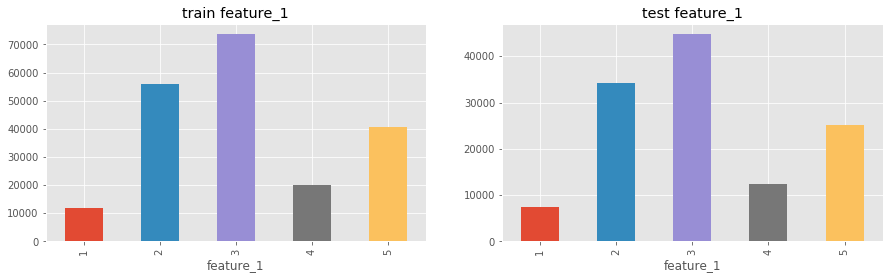

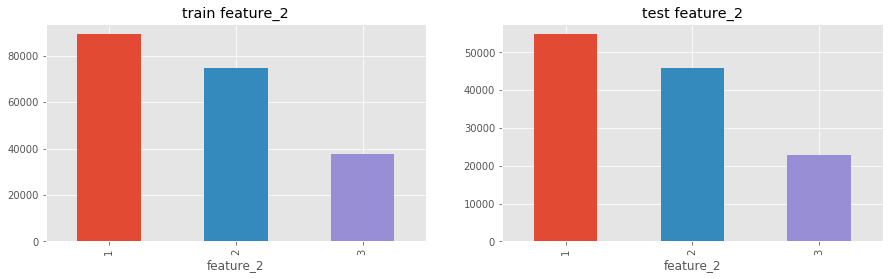

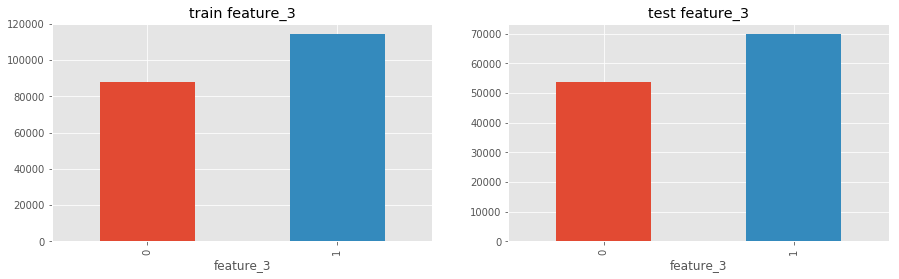

In [16]:
features = ['feature_1', 'feature_2', 'feature_3']
for feature in features:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    train_df.groupby(feature).count()['first_active_month'].plot(kind='bar',
                                                                 title='train {}'.format(feature),
                                                                 figsize=(15, 4),
                                                                 ax=axes[0])
    test_df.groupby(feature).count()['first_active_month'].plot(kind='bar',
                                                                title='test {}'.format(feature),
                                                                figsize=(15, 4))
    plt.show()

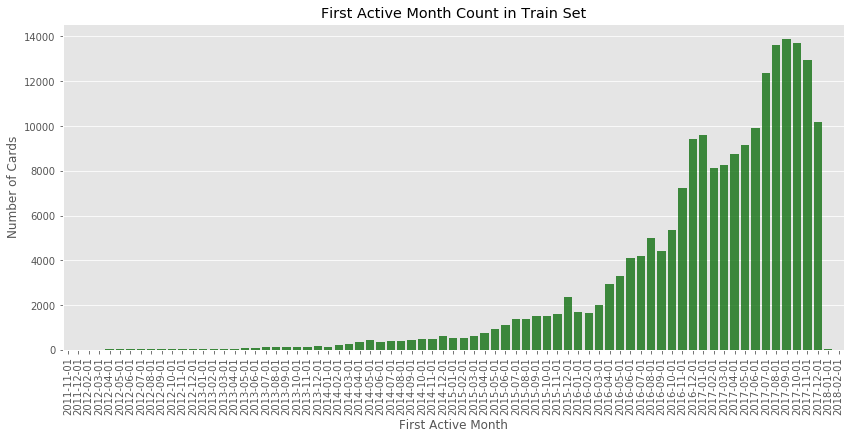

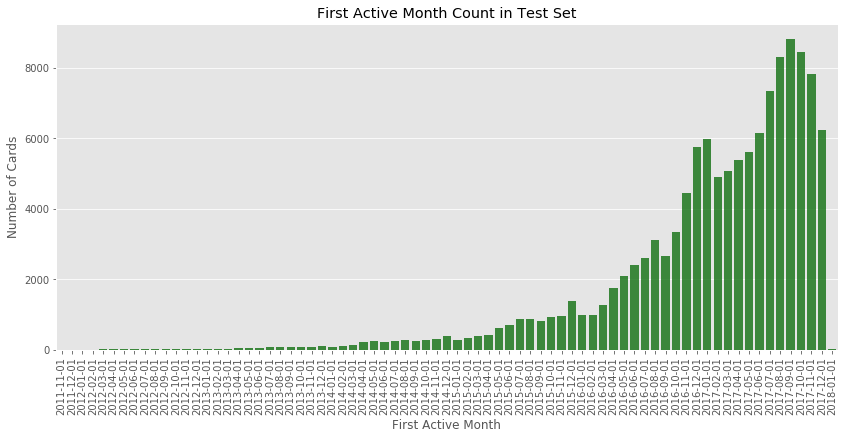

In [21]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First Active Month', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)
plt.title("First Active Month Count in Train Set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First Active Month', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)
plt.title("First Active Month Count in Test Set")
plt.show()

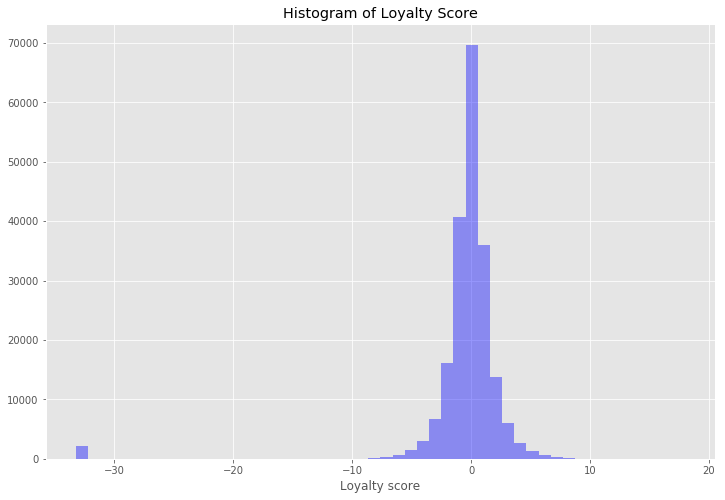

In [40]:
# plot the target distribution
plt.figure(figsize=(12,8))
sns.distplot(train_df['target'].values, bins=50, kde=False, color='blue')
plt.title('Histogram of Loyalty Score')
plt.xlabel('Loyalty score', fontsize=12)
plt.show()